In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

import pathlib
import random
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
dataPath = '/s/bach/m/under/epike919/Spring19/CS445/TermProjectStuff/cell_images/'
dataRoot = pathlib.Path(dataPath)

In [3]:
imageDirs = []
for item in dataRoot.iterdir():
    imageDirs.append(item)

dataRoot = []
for path in imageDirs:
    dataRoot.append(pathlib.Path(path))

In [4]:
labeledImages = []
label = 0
classes = sorted(os.walk(dataPath).__next__()[1])
# List each sub-directory (the classes)
for c in classes:
    c_dir = os.path.join(dataPath, c)
    walk = os.walk(c_dir).__next__()
    # Add each image to the training set
    for sample in walk[2]:
        # Only keeps jpeg images
        if sample.endswith('.png') or sample.endswith('.jpeg'):
            labeledImages.append( (label, os.path.join(c_dir, sample)) )
    label += 1
random.shuffle(labeledImages)

In [5]:
labeledTrain = []
labeledTest = []
i = 0
for image in labeledImages:
    if(i < .8*len(labeledImages)):
        labeledTrain.append(image)
        i += 1
    else:
        labeledTest.append(image)
trainPaths = [x[1] for x in labeledTrain]
trainLabels = [x[0] for x in labeledTrain]
testPaths = [x[1] for x in labeledTest]
testLabels = [x[0] for x in labeledTest]
testSize = len(testLabels)
trainSize = len(trainLabels)

In [6]:
#trainPaths = []
#trainLabels = []
#testPaths = []
#testLabels = []
#for i in range(len(imagePaths)):
#    if(i < .8*len(imagePaths)):
#        trainPaths.append(imagePaths[i])
#        trainLabels.append(labels[i])
#    else:
#        testPaths.append(imagePaths[i])
#        testLabels.append(labels[i])

def loadAndPreprocessImage(path):
  image = tf.read_file(path)
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize_images(image, [128, 128])
  image = image / 127.5 - 1.0  # normalize to [-1,1] range
  return image

In [7]:
def prepDataForConvNet(imagePaths, labels, batch_size):
    # Convert to Tensor
    imagePaths = tf.convert_to_tensor(imagePaths, dtype=tf.string)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    # Build a TF Queue, shuffle data
    image, label = tf.train.slice_input_producer([imagePaths, labels],
                                                 shuffle=True)

    # Read images from disk
    image = tf.read_file(image)
    image = tf.image.decode_png(image, channels=CHANNELS)

    # Resize images to a common size
    image = tf.image.resize_images(image, [128, 128])
    
    

    # Normalize
    image = image * 1.0/127.5 - 1.0

    # Create batches
    X, Y = tf.train.batch([image, label], batch_size=batch_size,
                          capacity=batch_size * 8,
                          num_threads=4)

    return X, Y

In [8]:
learning_rate = 0.001
num_steps = 850
batchSize = 128
display_step = 1

# Network Parameters
dropout = 0.75 # Dropout, probability to keep units

# Image Parameters_
N_CLASSES = 2 # CHANGE HERE, total number of classes
IMG_HEIGHT = 128 # CHANGE HERE, the image height to be resized to
IMG_WIDTH = 128 # CHANGE HERE, the image width to be resized to
CHANNELS = 3 # The 3 color channels, change to 1 if grayscale

In [9]:
trainImages, trainLabels = prepDataForConvNet(trainPaths, trainLabels, batchSize)
testImages, testLabels = prepDataForConvNet(testPaths, testLabels, 1)

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To 

In [10]:
#trainPathDS = tf.data.Dataset.from_tensor_slices(trainPaths)
#trainImageDS = trainPathDS.map(loadAndPreprocessImage, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#trainLabelDS = tf.data.Dataset.from_tensor_slices(tf.cast(trainLabels, tf.int64))
#trainDS = tf.data.Dataset.zip((trainImageDS, trainLabelDS))

#testPathDS = tf.data.Dataset.from_tensor_slices(testPaths)
#testImageDS = testPathDS.map(loadAndPreprocessImage, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#testLabelDS = tf.data.Dataset.from_tensor_slices(tf.cast(testLabels, tf.int64))
#testDS = tf.data.Dataset.zip((testImageDS, testLabelDS))

In [11]:
# Create model
def conv_net(images, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(images, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2
        conv1 = tf.layers.max_pooling2d(conv1, 5, 3)

        # Convolution Layer with 32 filters and a kernel size of 5
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2 
        conv2 = tf.layers.max_pooling2d(conv2, 5, 3)
        
        conv3 = tf.layers.conv2d(conv2, 128, 3)
        conv3 = tf.layers.max_pooling2d(conv3, 3, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv3)

        # Fully connected layer (in contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)
        # Because 'softmax_cross_entropy_with_logits' already apply softmax,
        # we only apply softmax to testing network
        out = tf.nn.softmax(out) if not is_training else out

    return out

In [12]:
logits_train = conv_net(trainImages, N_CLASSES, dropout, reuse=False, is_training=True)
# Create another graph for testing that reuse the same weights
logits_test = conv_net(trainImages, N_CLASSES, dropout, reuse=True, is_training=False)


logits_test_test = conv_net(testImages, N_CLASSES, dropout, reuse=True, is_training=False)

# Define loss and optimizer (with train logits, for dropout to take effect)
loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits_train, labels=trainLabels))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits_test, 1), tf.cast(trainLabels, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

correct_pred_test = tf.equal(tf.argmax(logits_test_test, 1), tf.cast(testLabels, tf.int64))
accuracy_test = tf.reduce_mean(tf.cast(correct_pred_test, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Saver object
saver = tf.train.Saver()

train_accs = []
train_losses = []

missedTestIndices = []

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Start the data queue
    tf.train.start_queue_runners()

    # Training cycle
    
    train_acc = 0;

    
    for step in range(1, num_steps+1):

        if step % display_step == 0:
            # Run optimization and calculate batch loss and accuracy
            _, loss, acc = sess.run([train_op, loss_op, accuracy])
            train_accs.append(acc)
            train_losses.append(loss)
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
        else:
            # Only run the optimization op (backprop)
            sess.run(train_op)
            
    for step in range(1, (math.ceil(trainSize/batchSize) )+1):
        # Run optimization and calculate batch loss and accuracy
        acc3 = sess.run(accuracy)
        train_acc += acc3
        if step % 5 == 0:
            # Run optimization and calculate batch loss and accuracy
            print("Step " + str(step) + ", Training observing only Accuracy= " + str(acc3))
  
      
    train_acc = train_acc/(math.ceil(trainSize/batchSize) )
    test_accuracy = 0;
    
    for step in range(1, testSize + 1):
        acc2 = sess.run(accuracy_test)
        if(acc2 == 0):
            missedTestIndices.append(step)
        test_accuracy += acc2


        if step % 100 == 0:
            # Run optimization and calculate batch loss and accuracy
            print("Step " + str(step) + ", Testing Accuracy= " + str(acc2))

            
    test_accuracy = test_accuracy/testSize
    print("Optimization Finished! " + str(test_accuracy))
    # Save your model
    saver.save(sess, 'my_tf_model4')

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Step 1, Minibatch Loss= 0.7555, Training Accuracy= 0.516
Step 2, Minibatch Loss= 1.0981, Training Accuracy= 0.500
Step 3, Minibatch Loss= 1.4729, Training Accuracy= 0.492
Step 4, Minibat

Step 101, Minibatch Loss= 0.2005, Training Accuracy= 0.906
Step 102, Minibatch Loss= 0.1857, Training Accuracy= 0.938
Step 103, Minibatch Loss= 0.2254, Training Accuracy= 0.914
Step 104, Minibatch Loss= 0.1837, Training Accuracy= 0.945
Step 105, Minibatch Loss= 0.2762, Training Accuracy= 0.891
Step 106, Minibatch Loss= 0.1200, Training Accuracy= 0.961
Step 107, Minibatch Loss= 0.3103, Training Accuracy= 0.867
Step 108, Minibatch Loss= 0.2107, Training Accuracy= 0.945
Step 109, Minibatch Loss= 0.2526, Training Accuracy= 0.938
Step 110, Minibatch Loss= 0.2118, Training Accuracy= 0.945
Step 111, Minibatch Loss= 0.1815, Training Accuracy= 0.945
Step 112, Minibatch Loss= 0.1832, Training Accuracy= 0.945
Step 113, Minibatch Loss= 0.1602, Training Accuracy= 0.930
Step 114, Minibatch Loss= 0.1426, Training Accuracy= 0.961
Step 115, Minibatch Loss= 0.1654, Training Accuracy= 0.938
Step 116, Minibatch Loss= 0.2880, Training Accuracy= 0.906
Step 117, Minibatch Loss= 0.1540, Training Accuracy= 0.9

Step 240, Minibatch Loss= 0.1220, Training Accuracy= 0.961
Step 241, Minibatch Loss= 0.1340, Training Accuracy= 0.953
Step 242, Minibatch Loss= 0.1554, Training Accuracy= 0.938
Step 243, Minibatch Loss= 0.3026, Training Accuracy= 0.945
Step 244, Minibatch Loss= 0.1129, Training Accuracy= 0.953
Step 245, Minibatch Loss= 0.1056, Training Accuracy= 0.961
Step 246, Minibatch Loss= 0.2054, Training Accuracy= 0.914
Step 247, Minibatch Loss= 0.2849, Training Accuracy= 0.859
Step 248, Minibatch Loss= 0.1281, Training Accuracy= 0.945
Step 249, Minibatch Loss= 0.0625, Training Accuracy= 0.984
Step 250, Minibatch Loss= 0.1432, Training Accuracy= 0.945
Step 251, Minibatch Loss= 0.1692, Training Accuracy= 0.938
Step 252, Minibatch Loss= 0.1365, Training Accuracy= 0.945
Step 253, Minibatch Loss= 0.1850, Training Accuracy= 0.922
Step 254, Minibatch Loss= 0.2155, Training Accuracy= 0.953
Step 255, Minibatch Loss= 0.1616, Training Accuracy= 0.938
Step 256, Minibatch Loss= 0.0982, Training Accuracy= 0.9

Step 379, Minibatch Loss= 0.1588, Training Accuracy= 0.930
Step 380, Minibatch Loss= 0.1988, Training Accuracy= 0.961
Step 381, Minibatch Loss= 0.1260, Training Accuracy= 0.969
Step 382, Minibatch Loss= 0.2225, Training Accuracy= 0.922
Step 383, Minibatch Loss= 0.2243, Training Accuracy= 0.930
Step 384, Minibatch Loss= 0.1747, Training Accuracy= 0.930
Step 385, Minibatch Loss= 0.0746, Training Accuracy= 0.984
Step 386, Minibatch Loss= 0.1449, Training Accuracy= 0.953
Step 387, Minibatch Loss= 0.1822, Training Accuracy= 0.938
Step 388, Minibatch Loss= 0.3130, Training Accuracy= 0.938
Step 389, Minibatch Loss= 0.1126, Training Accuracy= 0.953
Step 390, Minibatch Loss= 0.2121, Training Accuracy= 0.945
Step 391, Minibatch Loss= 0.2093, Training Accuracy= 0.922
Step 392, Minibatch Loss= 0.1591, Training Accuracy= 0.930
Step 393, Minibatch Loss= 0.1187, Training Accuracy= 0.953
Step 394, Minibatch Loss= 0.0925, Training Accuracy= 0.977
Step 395, Minibatch Loss= 0.0905, Training Accuracy= 0.9

Step 518, Minibatch Loss= 0.2051, Training Accuracy= 0.930
Step 519, Minibatch Loss= 0.1401, Training Accuracy= 0.953
Step 520, Minibatch Loss= 0.1254, Training Accuracy= 0.961
Step 521, Minibatch Loss= 0.2120, Training Accuracy= 0.922
Step 522, Minibatch Loss= 0.1108, Training Accuracy= 0.953
Step 523, Minibatch Loss= 0.2292, Training Accuracy= 0.922
Step 524, Minibatch Loss= 0.1371, Training Accuracy= 0.977
Step 525, Minibatch Loss= 0.2214, Training Accuracy= 0.930
Step 526, Minibatch Loss= 0.1726, Training Accuracy= 0.930
Step 527, Minibatch Loss= 0.1303, Training Accuracy= 0.961
Step 528, Minibatch Loss= 0.1453, Training Accuracy= 0.945
Step 529, Minibatch Loss= 0.1519, Training Accuracy= 0.938
Step 530, Minibatch Loss= 0.1838, Training Accuracy= 0.930
Step 531, Minibatch Loss= 0.1194, Training Accuracy= 0.969
Step 532, Minibatch Loss= 0.1750, Training Accuracy= 0.953
Step 533, Minibatch Loss= 0.1201, Training Accuracy= 0.953
Step 534, Minibatch Loss= 0.1122, Training Accuracy= 0.9

Step 657, Minibatch Loss= 0.1397, Training Accuracy= 0.953
Step 658, Minibatch Loss= 0.1165, Training Accuracy= 0.969
Step 659, Minibatch Loss= 0.1082, Training Accuracy= 0.969
Step 660, Minibatch Loss= 0.2311, Training Accuracy= 0.945
Step 661, Minibatch Loss= 0.1303, Training Accuracy= 0.953
Step 662, Minibatch Loss= 0.1171, Training Accuracy= 0.953
Step 663, Minibatch Loss= 0.1396, Training Accuracy= 0.945
Step 664, Minibatch Loss= 0.1526, Training Accuracy= 0.961
Step 665, Minibatch Loss= 0.3099, Training Accuracy= 0.938
Step 666, Minibatch Loss= 0.2141, Training Accuracy= 0.914
Step 667, Minibatch Loss= 0.1826, Training Accuracy= 0.945
Step 668, Minibatch Loss= 0.2325, Training Accuracy= 0.953
Step 669, Minibatch Loss= 0.1734, Training Accuracy= 0.930
Step 670, Minibatch Loss= 0.1162, Training Accuracy= 0.961
Step 671, Minibatch Loss= 0.2086, Training Accuracy= 0.922
Step 672, Minibatch Loss= 0.1302, Training Accuracy= 0.953
Step 673, Minibatch Loss= 0.1312, Training Accuracy= 0.9

Step 796, Minibatch Loss= 0.1139, Training Accuracy= 0.977
Step 797, Minibatch Loss= 0.1957, Training Accuracy= 0.945
Step 798, Minibatch Loss= 0.1359, Training Accuracy= 0.953
Step 799, Minibatch Loss= 0.1683, Training Accuracy= 0.945
Step 800, Minibatch Loss= 0.1618, Training Accuracy= 0.961
Step 801, Minibatch Loss= 0.0923, Training Accuracy= 0.977
Step 802, Minibatch Loss= 0.1623, Training Accuracy= 0.938
Step 803, Minibatch Loss= 0.2336, Training Accuracy= 0.930
Step 804, Minibatch Loss= 0.1469, Training Accuracy= 0.938
Step 805, Minibatch Loss= 0.0998, Training Accuracy= 0.961
Step 806, Minibatch Loss= 0.1467, Training Accuracy= 0.945
Step 807, Minibatch Loss= 0.2254, Training Accuracy= 0.938
Step 808, Minibatch Loss= 0.1765, Training Accuracy= 0.945
Step 809, Minibatch Loss= 0.1249, Training Accuracy= 0.945
Step 810, Minibatch Loss= 0.1707, Training Accuracy= 0.945
Step 811, Minibatch Loss= 0.1136, Training Accuracy= 0.984
Step 812, Minibatch Loss= 0.1818, Training Accuracy= 0.9

Exception in thread QueueRunnerThread-batch_1/fifo_queue-batch_1/fifo_queue_enqueue:
Traceback (most recent call last):
  File "/usr/local/anaconda3-4.4.0/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/anaconda3-4.4.0/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/training/queue_runner_impl.py", line 257, in _run
    enqueue_callable()
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1257, in _single_operation_run
    self._call_tf_sessionrun(None, {}, [], target_list, None)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1407, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.CancelledError: Enqueue operation was cancelled
	 [[{{node batch_1/fifo_queue_enqueue}}]]

Exception in thread QueueRun

ERROR:tensorflow:Exception in QueueRunner: Enqueue operation was cancelled
	 [[{{node input_producer_1/input_producer/input_producer_EnqueueMany}}]]



Exception in thread QueueRunnerThread-input_producer_1/input_producer-input_producer_1/input_producer/input_producer_EnqueueMany:
Traceback (most recent call last):
  File "/usr/local/anaconda3-4.4.0/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/anaconda3-4.4.0/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/training/queue_runner_impl.py", line 257, in _run
    enqueue_callable()
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1257, in _single_operation_run
    self._call_tf_sessionrun(None, {}, [], target_list, None)
  File "/usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1407, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.CancelledError: Enqueue operation was cancelled
	 [[{{node input_producer

ERROR:tensorflow:Exception in QueueRunner: Enqueue operation was cancelled
	 [[{{node batch_1/fifo_queue_enqueue}}]]
ERROR:tensorflow:Exception in QueueRunner: Enqueue operation was cancelled
	 [[{{node batch/fifo_queue_enqueue}}]]


In [21]:
test_accuracy

0.9560878243512974

In [22]:
train_acc

0.9589505057803468

In [15]:
#LEFT OFF AT PIPE THE DATASET TO A MODEL
#NEED TO:
#    SEPERATE DATA INTO TRAINING AND TESTING ###DONE
#    TRAIN MODEL
#    TEST MODEL

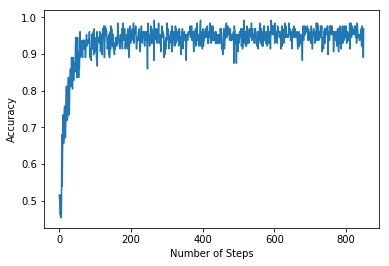

In [16]:
plt.plot(train_accs)
plt.ylabel("Accuracy")
plt.xlabel("Number of Steps")
plt.show()

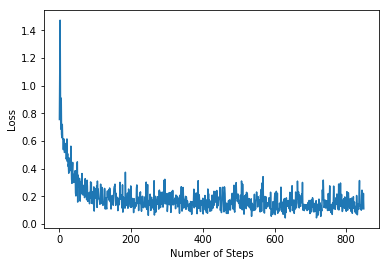

In [17]:
plt.plot(train_losses)
plt.ylabel("Loss")
plt.xlabel("Number of Steps")
plt.show()

In [18]:
def extractIMGtype(path):
    type = ""
    splitPath = path.split("/")
    for i in range(len(splitPath)):
        if (splitPath[i] == "cell_images"):
            type = splitPath[i+1]
    return type

In [19]:
print(len(missedTestIndices))

242


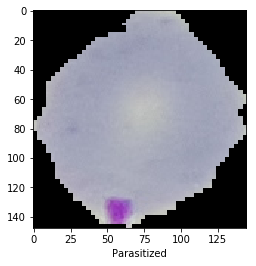

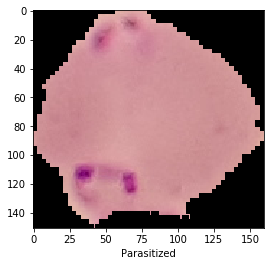

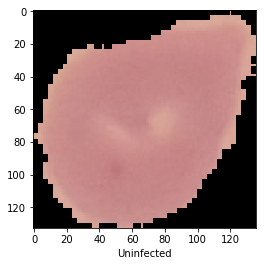

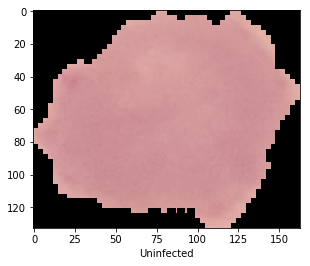

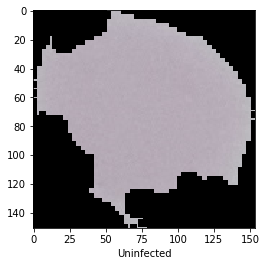

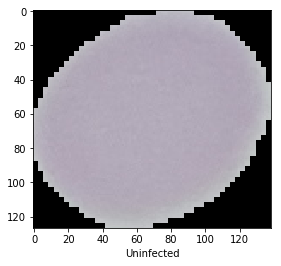

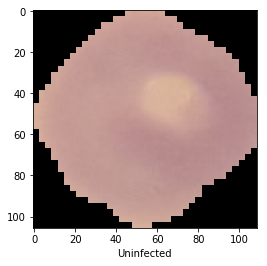

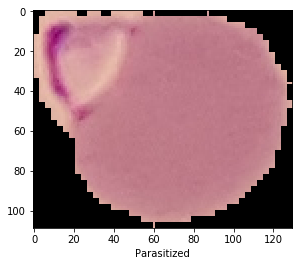

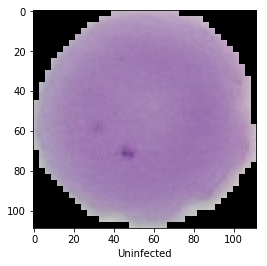

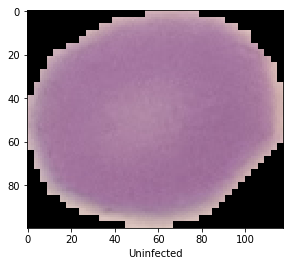

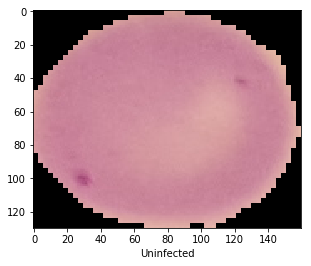

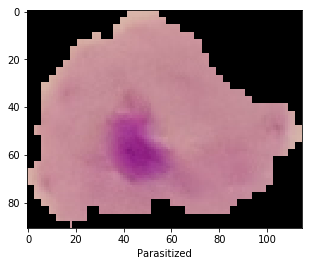

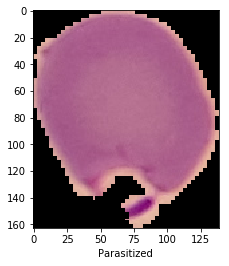

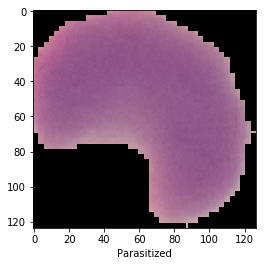

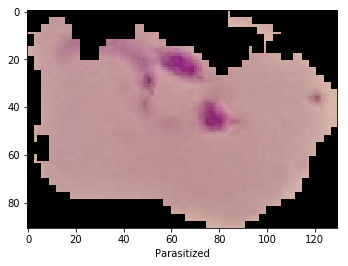

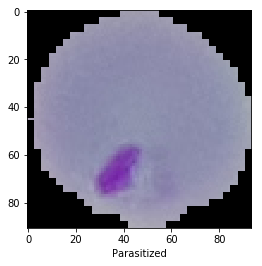

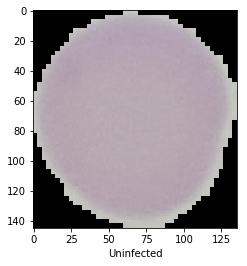

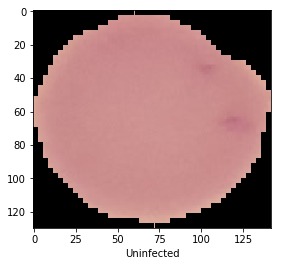

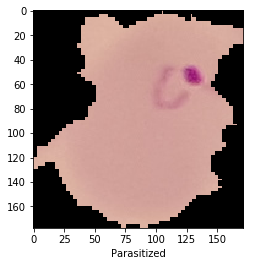

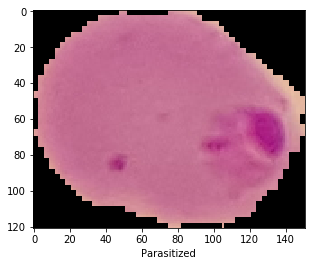

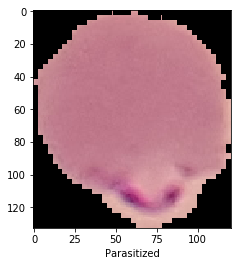

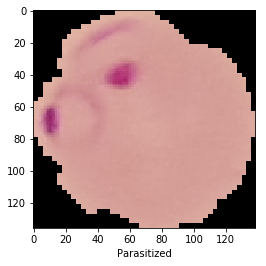

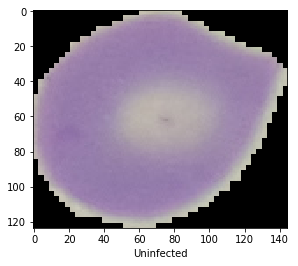

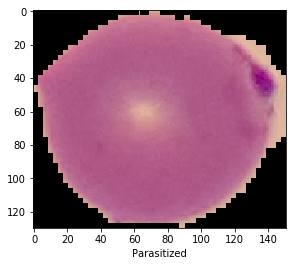

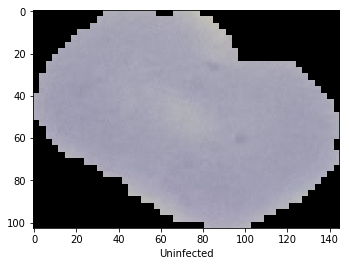

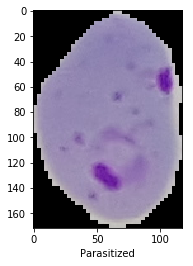

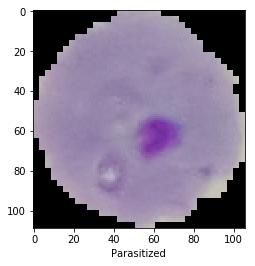

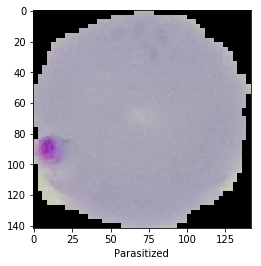

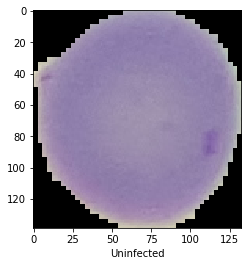

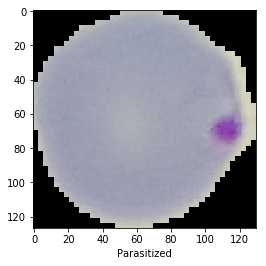

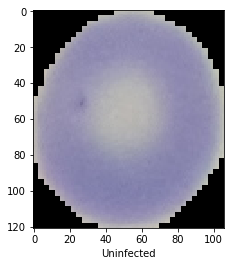

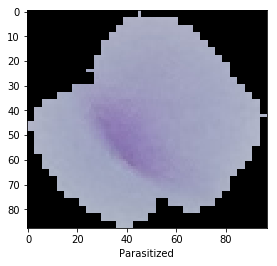

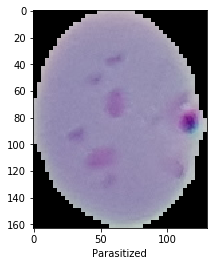

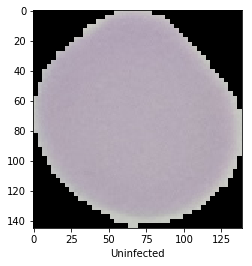

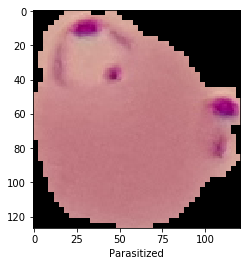

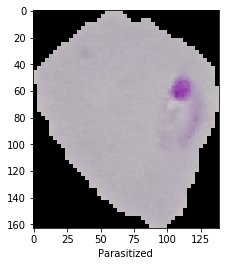

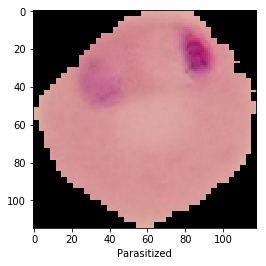

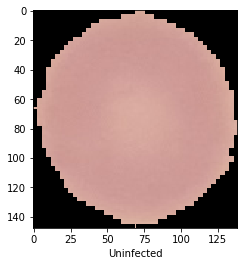

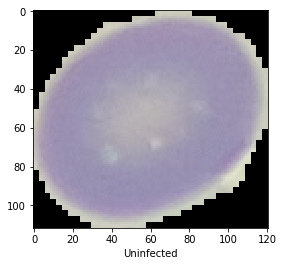

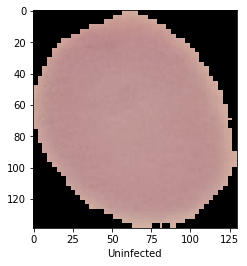

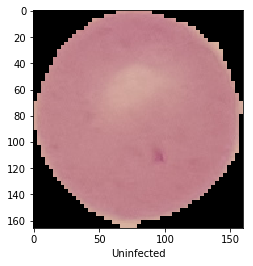

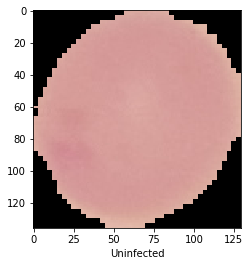

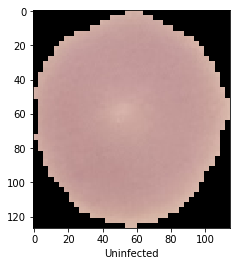

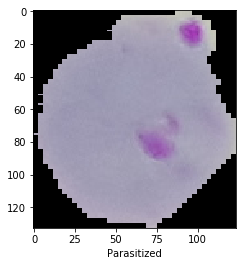

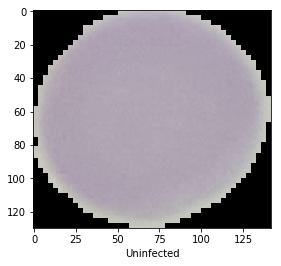

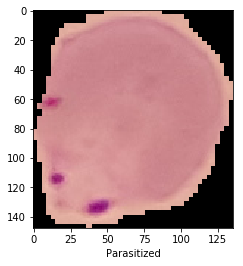

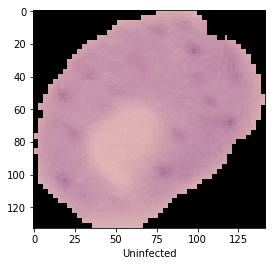

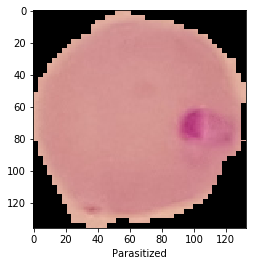

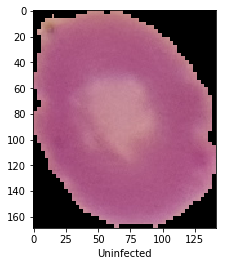

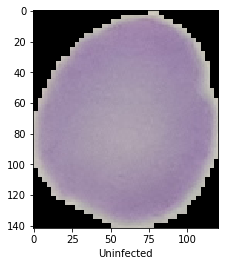

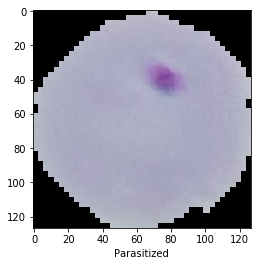

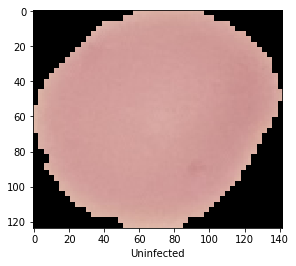

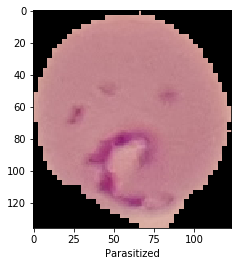

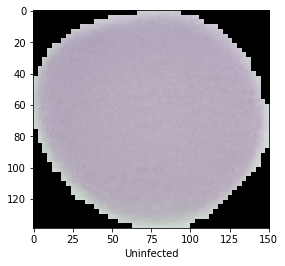

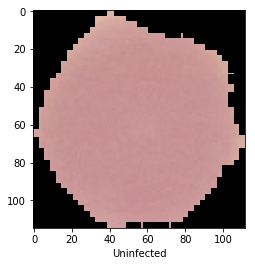

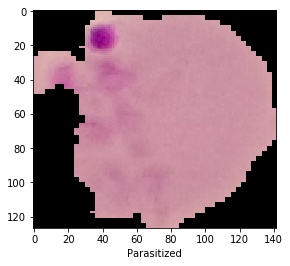

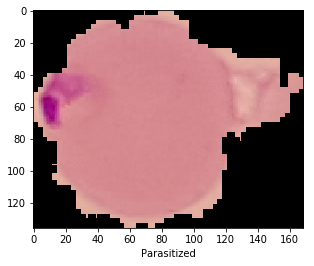

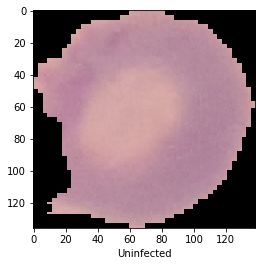

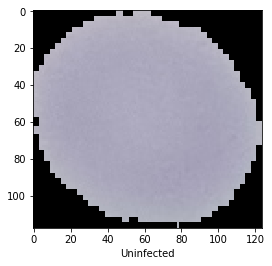

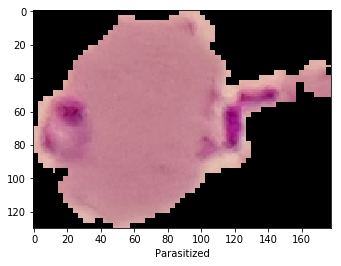

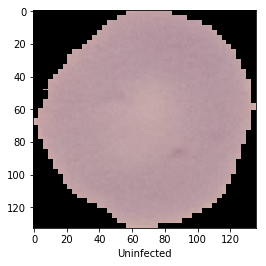

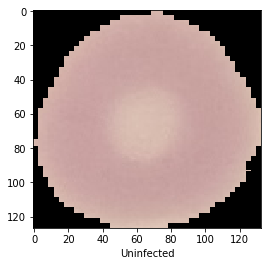

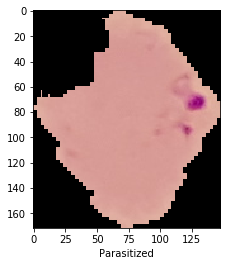

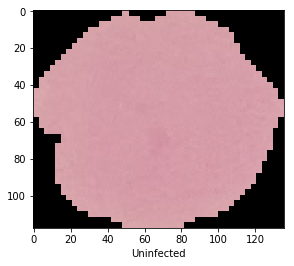

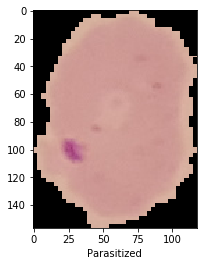

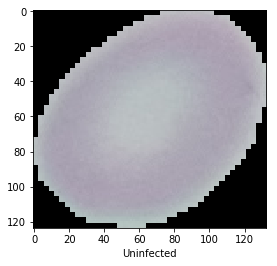

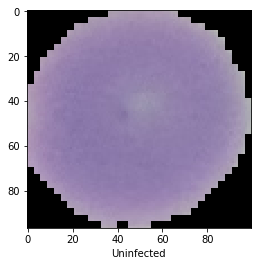

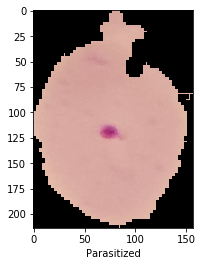

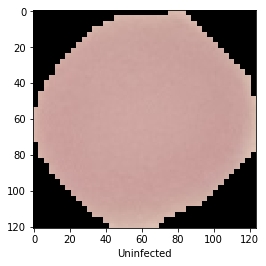

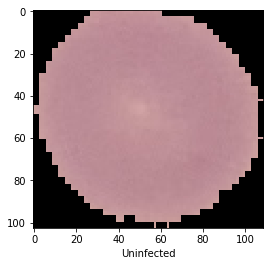

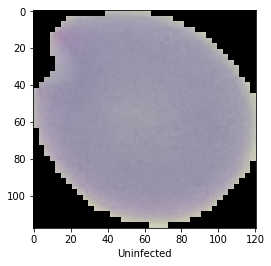

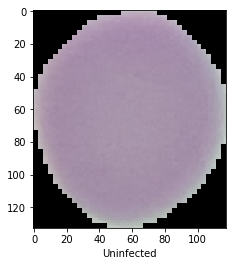

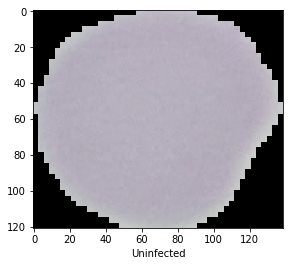

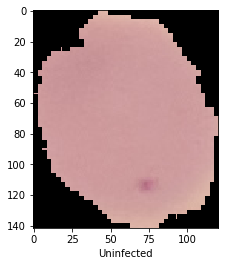

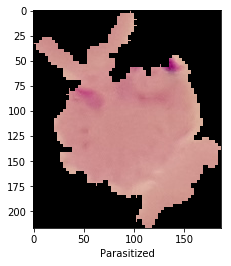

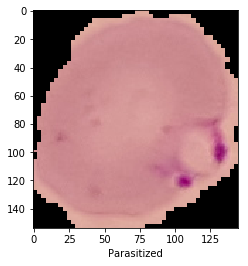

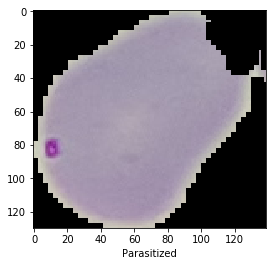

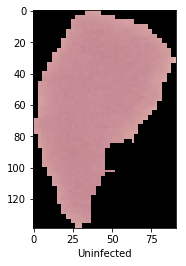

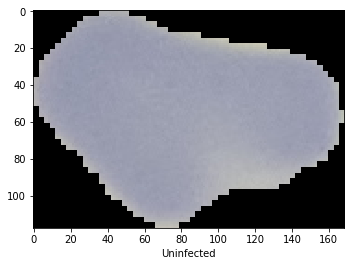

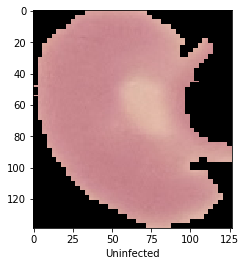

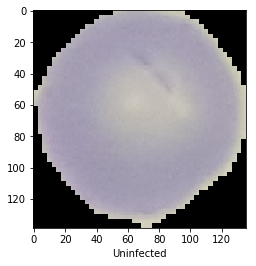

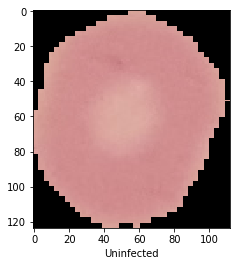

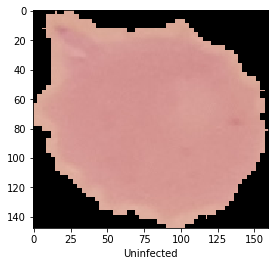

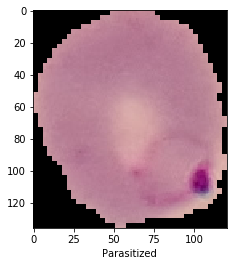

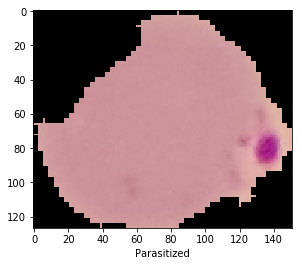

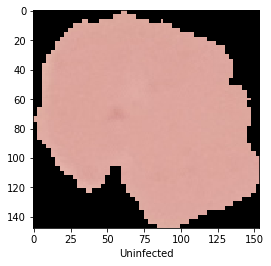

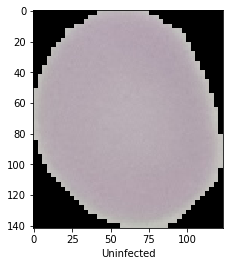

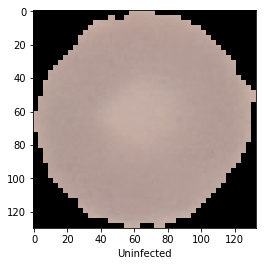

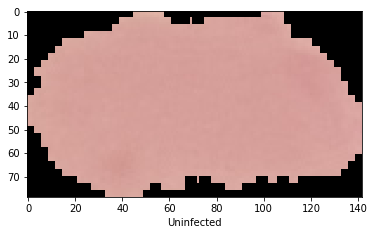

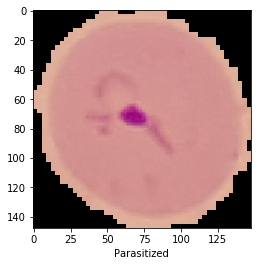

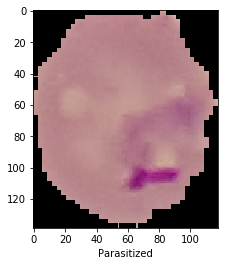

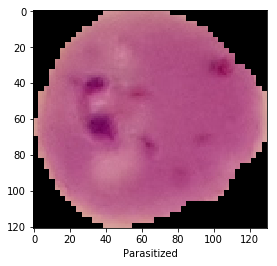

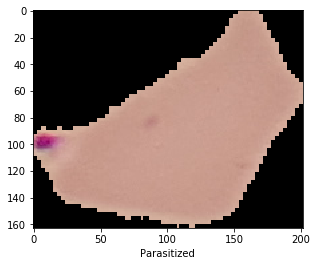

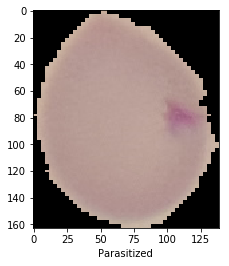

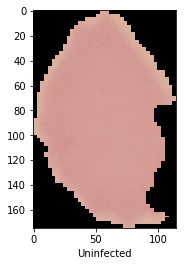

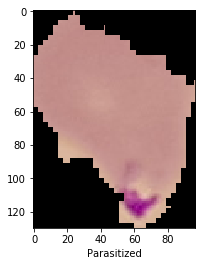

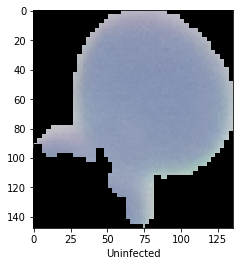

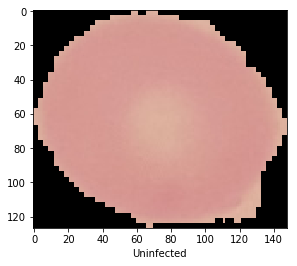

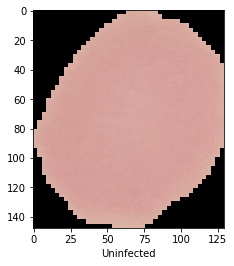

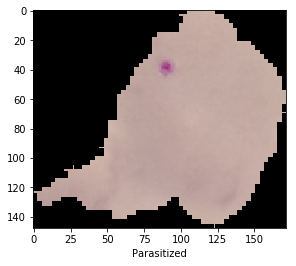

In [23]:
#random.shuffle(missedTestIndices)
for i in range(0,100):
    plt.imshow(mpimg.imread(testPaths[missedTestIndices[i]]))
    plt.xlabel(extractIMGtype(testPaths[missedTestIndices[i]]))
    plt.show()